In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

In [2]:
train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('test.csv', index_col=0)

In [3]:
train.shape, test.shape

((1460, 80), (1459, 79))

In [4]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


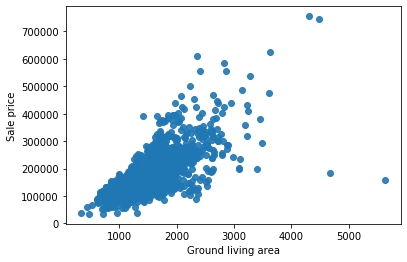

In [6]:
plt.scatter(train["GrLivArea"], train["SalePrice"], alpha=0.9)
plt.xlabel("Ground living area")
plt.ylabel("Sale price")
plt.show()

train = train[train["GrLivArea"] < 4200]

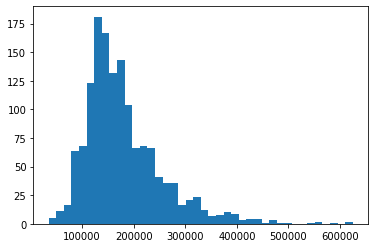

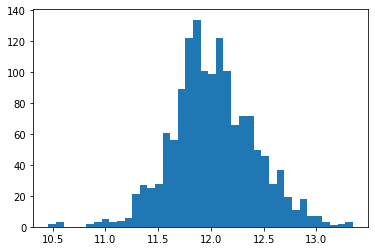

In [7]:
X = pd.concat([train.drop("SalePrice", axis=1), test])

plt.hist(train["SalePrice"], bins = 40)
plt.show()
y = np.log(train["SalePrice"])
plt.hist(y, bins = 40)
plt.show()

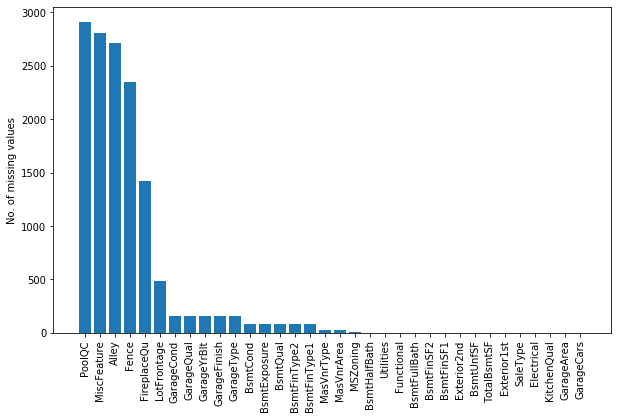

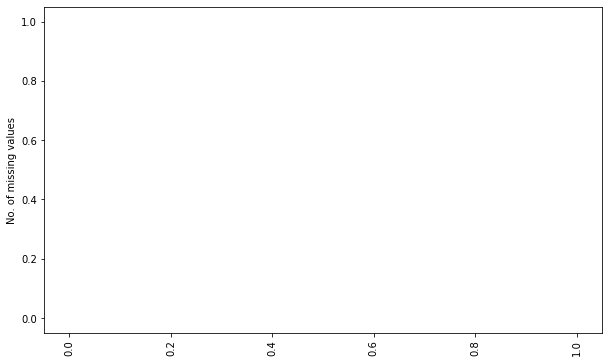

/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3429: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


In [8]:
nans = X.isna().sum().sort_values(ascending=False)
nans = nans[nans > 0]
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(nans.index, nans.values)
ax.set_ylabel("No. of missing values")
ax.xaxis.set_tick_params(rotation=90)
plt.show()

cols = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageCond", "GarageQual", "GarageFinish", "GarageType", "BsmtCond", "BsmtExposure", "BsmtQual", "BsmtFinType2", "BsmtFinType1"]
X[cols] = X[cols].fillna("None")

cols = ["GarageYrBlt", "MasVnrArea", "BsmtHalfBath", "BsmtFullBath", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "GarageCars"]
X[cols] = X[cols].fillna(X[cols].mean())
cols = ["MasVnrType", "MSZoning", "Utilities", "Exterior1st", "Exterior2nd", "SaleType", "Electrical", "KitchenQual", "Functional"]
X[cols] = X.groupby("Neighborhood")[cols].transform(lambda x: x.fillna(x.mode()[0]))
cols = ["GarageArea", "LotFrontage"]
X[cols] = X.groupby("Neighborhood")[cols].transform(lambda x: x.fillna(x.mean()))

nans = X.isna().sum().sort_values(ascending=False)
nans = nans[nans > 0]
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(nans.index, nans.values)
ax.set_ylabel("No. of missing values")
ax.xaxis.set_tick_params(rotation=90)
plt.show()

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in X.columns:
    if X[i].dtype in numeric_dtypes:
        numerics2.append(i)

skew_features = X[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    X[i] = boxcox1p(X[i], boxcox_normmax(X[i] + 1))

    X["TotalSF"] = X["GrLivArea"] + X["TotalBsmtSF"]
X["TotalPorchSF"] = X["OpenPorchSF"] + X["EnclosedPorch"] + X["3SsnPorch"] + X["ScreenPorch"]
X["TotalBath"] = X["FullBath"] + X["BsmtFullBath"] + 0.5 * (X["BsmtHalfBath"] + X["HalfBath"])
X['Total_sqr_footage'] = X['BsmtFinSF1'] + X['BsmtFinSF2'] + X['1stFlrSF'] + X['2ndFlrSF']

cols = ["MSSubClass", "YrSold"]
X[cols] = X[cols].astype("category")

X = X.drop(['Utilities', 'Street', 'PoolQC', ], axis=1)

cols = X.select_dtypes(np.number).columns
X[cols] = RobustScaler().fit_transform(X[cols])

#X['haspool'] = X['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
#X['has2ndfloor'] = X['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
#X['hasgarage'] = X['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
#X['hasbsmt'] = X['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
#X['hasfireplace'] = X['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

X = pd.get_dummies(X)

In [9]:
X.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,-0.253151,-0.255844,0.5,0.000000,0.625000,0.256410,1.092620,0.362988,0.0,-0.666217,...,0,0,0,1,0,0,0,0,1,0
2,0.485949,0.036226,0.0,2.919402,0.062500,-0.435897,0.000000,0.617959,0.0,-0.346200,...,0,0,0,1,0,0,0,0,1,0
3,-0.100382,0.403878,0.5,0.000000,0.583333,0.230769,0.998539,0.134774,0.0,-0.057510,...,0,0,0,1,0,0,0,0,1,0
4,-0.514051,0.024208,0.5,0.000000,-1.208333,-0.589744,0.000000,-0.194538,0.0,0.121476,...,0,0,0,1,1,0,0,0,0,0
5,0.673572,0.963122,1.0,0.000000,0.562500,0.179487,1.430579,0.312196,0.0,0.039080,...,0,0,0,1,0,0,0,0,1,0


In [13]:
X_train1 = X.loc[train.index
X_test_sub = X.loc[test.index]

overfit = []
for i in X_train1.columns:
    counts = X_train1[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
X_train1 = X_train1.drop(overfit, axis=1).copy()
X_test_sub = X_test_sub.drop(overfit, axis=1).copy()

train_size = 0.8
separator = round(len(X_train1.index)*train_size)


X_train, y_train = X_train1.iloc[0:separator], y.iloc[0:separator]
X_test, y_test = X_train1.iloc[separator:], y.iloc[separator:]

In [18]:
gbr = ensemble.GradientBoostingRegressor(learning_rate=0.02, n_estimators=2000,
                                           max_depth=5, min_samples_split=2,
                                           loss='ls', max_features=35)

xgb = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                       max_depth=3, min_child_weight=0,
                       gamma=0, subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:squarederror', nthread=-1,
                       scale_pos_weight=1, seed=27,
                       reg_alpha=0.00006)

lgbm = LGBMRegressor(objective='regression',
                         num_leaves=4,
                         learning_rate=0.01,
                         n_estimators=5000,
                         max_bin=200,
                         bagging_fraction=0.75,
                         bagging_freq=5,
                         bagging_seed=7,
                         feature_fraction=0.2,
                         feature_fraction_seed=7,
                         verbose=-1,
                                       )

cb = CatBoostRegressor(loss_function='RMSE', logging_level='Silent')

In [22]:
def mean_cross_val(model, X, y):
    score = cross_val_score(model, X, y, cv=5)
    mean = score.mean()
    return mean

gbr.fit(X_train, y_train)   
preds = gbr.predict(X_test) 
preds_test_gbr = gbr.predict(X_test_sub)
mae_gbr = mean_absolute_error(y_test, preds)
rmse_gbr = np.sqrt(mean_squared_error(y_test, preds))
score_gbr = gbr.score(X_test, y_test)
cv_gbr = mean_cross_val(gbr, X_train1, y)

lgbm.fit(X_train, y_train)   
preds = lgbm.predict(X_test) 
preds_test_lgbm = lgbm.predict(X_test_sub)
mae_lgbm = mean_absolute_error(y_test, preds)
rmse_lgbm = np.sqrt(mean_squared_error(y_test, preds))
score_lgbm = lgbm.score(X_test, y_test)
cv_lgbm = mean_cross_val(lgbm, X_train1, y)

cb.fit(X_train, y_train)   
preds = cb.predict(X_test) 
preds_test_cb = cb.predict(X_test_sub)
mae_cb = mean_absolute_error(y_test, preds)
rmse_cb = np.sqrt(mean_squared_error(y_test, preds))
score_cb = cb.score(X_test, y_test)
cv_cb = mean_cross_val(cb, X_train1, y)

xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.01, max_delta_step=0, max_depth=3,
             min_child_weight=0, missing=nan, monotone_constraints=None,
             n_estimators=3460, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=27, reg_alpha=6e-05,
             reg_lambda=1, scale_pos_weight=1, seed=27, subsample=0.7,
             tree_method=None, validate_parameters=False, verbosity=None)

In [25]:
preds = xgb.predict(X_test) 
preds_test_xgb = xgb.predict(X_test_sub)
mae_xgb = mean_absolute_error(y_test, preds)
rmse_xgb = np.sqrt(mean_squared_error(y_test, preds))
score_xgb = cb.score(X_test, y_test)
cv_xgb = mean_cross_val(xgb, X_train1, y)

In [35]:
model_performances = pd.DataFrame({
    "Model" : ["Gradient Boosting Regression", "XGBoost", "LGBM", "CatBoost"],
    "CV(5)" : [str(cv_gbr)[0:5], str(cv_xgb)[0:5], str(cv_lgbm)[0:5], str(cv_cb)[0:5]],
    "MAE" : [str(mae_gbr)[0:5], str(mae_xgb)[0:5], str(mae_lgbm)[0:5], str(mae_cb)[0:5]],
    "RMSE" : [str(rmse_gbr)[0:5], str(rmse_xgb)[0:5], str(rmse_lgbm)[0:5], str(rmse_cb)[0:5]],
    "Score" : [str(score_gbr)[0:5], str(score_xgb)[0:5], str(score_lgbm)[0:5], str(score_cb)[0:5]]
})

print("Sorted by Score:")
print(model_performances.sort_values(by="Score", ascending=False))

Sorted by Score:
                          Model  CV(5)    MAE   RMSE  Score
1                       XGBoost  0.917  0.078  0.114  0.915
3                      CatBoost  0.917  0.077  0.110  0.915
0  Gradient Boosting Regression  0.913  0.078  0.112  0.913
2                          LGBM  0.914  0.078  0.112  0.913


In [36]:
def blend_models_predict(X, a, b, c, d):
    return ((a * gbr.predict(X)) +  (b * xgb.predict(X)) +  (c * lgbm.predict(X)) + (d * cb.predict(X)))

subm = np.exp(blend_models_predict(X_test_sub, 0.1, 0.4, 0.1, 0.4))

In [37]:
submission = pd.DataFrame({'Id': X_test_sub.index,
                       'SalePrice': subm})

q1 = submission['SalePrice'].quantile(0.0042)
q2 = submission['SalePrice'].quantile(0.99)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)

submission.to_csv("submission_new4.csv", index=False)